In [258]:
# Libraries and data setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

RECALL_THRESHOLD = 0.6
THRESHOLD = 0.6
DEFAULT_COLOR = '#4682B4'

df = pd.read_parquet('../data/analytic_df.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47325 entries, 0 to 47324
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      47325 non-null  object 
 1   manual_rating           47325 non-null  int64  
 2   model                   47325 non-null  object 
 3   model_rating            47325 non-null  int64  
 4   processing_time         45321 non-null  float64
 5   real_rating             47325 non-null  int64  
 6   language                47325 non-null  object 
 7   is_inconsistent_manual  47325 non-null  int64  
 8   is_inconsistent_model   47325 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 3.2+ MB


In [259]:
def gen_model_metrics_df(df):
    df_cleaned = df.dropna(
        subset=['model', 'is_inconsistent_manual', 'is_inconsistent_model']
    ).copy()

    df_cleaned['is_inconsistent_manual'] = df_cleaned['is_inconsistent_manual'].astype(bool)
    df_cleaned['is_inconsistent_model'] = df_cleaned['is_inconsistent_model'].astype(bool)

    def calculate_metrics_for_group(group):
        y_true = group['is_inconsistent_manual']
        y_pred = group['is_inconsistent_model']

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'recall':   recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0),
            'avg_processing_time': group['processing_time'].mean()
        }
        return pd.Series(metrics)

    model_metrics_df = (
        df_cleaned
        .groupby('model')
        .apply(calculate_metrics_for_group)
        .round(4)
        .sort_values('f1_score', ascending=False)
    )

    return model_metrics_df.reset_index()

model_metrics_df = gen_model_metrics_df(df)
model_metrics_pt_df = gen_model_metrics_df(df[df['language']=='pt'])
model_metrics_en_df = gen_model_metrics_df(df[df['language']=='en'])

display(model_metrics_df.head())

,model,accuracy,recall,f1_score,avg_processing_time
0,stablelm2:12b,0.874,0.6973,0.6719,7.8240
1,llama2:7b,0.848,0.7676,0.6514,5.2603
2,everythinglm:13b,0.849,0.6541,0.6158,9.8178
3,mistral-nemo:12b,0.870,0.5622,0.6154,6.6772
4,orca2:7b,0.871,0.5459,0.6103,4.9870


In [260]:
def gen_model_groups(df, n_best=3, n_fast=3, suffix=''):
    df_filtered = df[~df['model'].str.startswith('gpt')].copy()

    base_groups = {
        'all-best': df_filtered['model'].tolist(),
        f'best-{n_best}': df_filtered.nlargest(n_best, 'f1_score')['model'].tolist(),
        f'fast-{n_fast}': df_filtered.nsmallest(n_fast, 'avg_processing_time')['model'].tolist()
    }
    
    if suffix:
        suffixed_groups = {f"{k}{suffix}": v for k, v in base_groups.items()}
    else:
        suffixed_groups = base_groups

    final_groups = {f"group:{k}": v for k, v in suffixed_groups.items()}
    
    return final_groups

N_BEST = 3
N_FAST = 3

df_filtered = model_metrics_df[model_metrics_df['f1_score'] >= THRESHOLD]
df_pt_filtered = model_metrics_pt_df[model_metrics_pt_df['f1_score'] >= THRESHOLD]
df_en_filtered = model_metrics_en_df[model_metrics_en_df['f1_score'] >= THRESHOLD]

groups = gen_model_groups(df_filtered, n_best=N_BEST, n_fast=N_FAST)
groups_pt = gen_model_groups(df_pt_filtered, n_best=N_BEST, n_fast=N_FAST, suffix='-pt')
groups.update(groups_pt)
groups_en = gen_model_groups(df_en_filtered, n_best=N_BEST, n_fast=N_FAST, suffix='-en')
groups.update(groups_en)

for label, models in groups.items():
    if label.startswith(f'group:best-{N_BEST}'):
        print(f"{label}: {models}")

group:best-3: ['stablelm2:12b', 'llama2:7b', 'everythinglm:13b']
group:best-3-pt: ['gemma:7b', 'phi4-reasoning:14b', 'orca2:7b']
group:best-3-en: ['stablelm2:12b', 'mistral-nemo:12b', 'llama2:7b']


In [261]:
def gen_group_rating_df(df, groups,
                      rating_col='model_rating',
                      feature_cols=None):
    if feature_cols is None:
        feature_cols = [
            'manual_rating', 'real_rating', 'language',
            'is_inconsistent_manual', 'is_inconsistent_model'
        ]

    id_features = df[['id'] + feature_cols].drop_duplicates(subset=['id'])
    
    all_group_results = []

    for group_name, models in groups.items():
        df_current_group_models = df[df['model'].isin(models)]

        if df_current_group_models.empty:
            continue

        def aggregate_group_stats(group):
            mean_rating = group[rating_col].mean()
            group_pred = int(round(mean_rating))
            
            total_votes = len(group)
            votes_for_pred = (group[rating_col] == group_pred).sum()
            
            certainty = (votes_for_pred / total_votes * 100) if total_votes > 0 else 0
            
            return pd.Series({
                'model_rating': group_pred,
                'certainty_pct': certainty,
                'processing_time': group['processing_time'].sum()
            })

        group_agg = (
            df_current_group_models
            .groupby('id')
            .apply(aggregate_group_stats)
            .reset_index()
        )
        
        group_agg['model'] = group_name
        all_group_results.append(group_agg)

    if not all_group_results:
        return pd.DataFrame()

    df_groups = pd.concat(all_group_results, ignore_index=True)
    df_groups = df_groups.merge(id_features, on='id', how='left')
    df_groups['is_group'] = True
    
    df_groups['is_inconsistent_model'] = (
            (df_groups['model_rating'].astype(int) - df_groups['real_rating'].astype(int)).abs() > 1
            ).astype(int)
    
    return df_groups

df_groups = gen_group_rating_df(df, groups)
df = pd.concat([df, df_groups], ignore_index=True)
df['is_group'] = df['is_group'].fillna(False).astype(int)

is_group_mask = df['is_group'] == 1

display(df[df['is_group']==True].sample(5))

model_metrics_df = gen_model_metrics_df(df)
model_metrics_pt_df = gen_model_metrics_df(df[df['language']=='pt'])
model_metrics_en_df = gen_model_metrics_df(df[df['language']=='en'])

display(model_metrics_df.sample(5))

,id,manual_rating,model,model_rating,processing_time,real_rating,language,is_inconsistent_manual,is_inconsistent_model,certainty_pct,is_group
49387,0d4de679ca9ef6ddcb7874991e184e9e9cc542c36f929d...,3,group:fast-3,4.0,16.895039,3,pt,0,0,66.666667,1
48921,925b7514c70b713203e38f0602c5b7ae4f2a252915d872...,3,group:best-3,3.0,12.670655,4,en,0,0,100.000000,1
50285,f2fe535b0f65ba8b90e64d7fd831c3d2218896ce5df753...,1,group:fast-3,2.0,8.499121,1,en,0,0,33.333333,1
52733,63cac98cd0af520fb0d1238581390d44dbde6851b38cb9...,4,group:fast-3-pt,4.0,15.767192,5,pt,0,0,100.000000,1
54937,9847048b4ec5191b0749ee314f78f58d0519f243e97612...,3,group:best-3-en,3.0,13.859329,4,pt,0,0,66.666667,1


,model,accuracy,recall,f1_score,avg_processing_time
50,deepseek-r1:7b,0.6790,0.6000,0.4088,3.7957
20,orca-mini:7b,0.8360,0.5946,0.5729,4.9955
35,stablelm2:1.6b,0.8088,0.5027,0.4934,1.0674
26,llama3.2:3b,0.8420,0.5081,0.5434,1.6676
33,yi:9b,0.8240,0.4973,0.5111,7.0719


In [262]:
def gen_metrics_df(overall_df, pt_df, en_df):
    def _calculate_derived(df):
        metrics_df = df.copy()
        metrics_df['time_log'] = np.log1p(metrics_df['avg_processing_time'])
        metrics_df['time_efficiency_log'] = metrics_df['f1_score'] / metrics_df['time_log']
        return metrics_df

    df_o = _calculate_derived(overall_df)
    
    df_pt = _calculate_derived(pt_df)
    df_pt = df_pt.rename(columns={col: col + '_pt' for col in df_pt.columns if col != 'model'})

    df_en = _calculate_derived(en_df)
    df_en = df_en.rename(columns={col: col + '_en' for col in df_en.columns if col != 'model'})

    metrics_df = df_o.merge(df_pt, on='model', how='outer')
    metrics_df = metrics_df.merge(df_en, on='model', how='outer')

    base_metrics = [col for col in metrics_df.columns if not col.endswith(('_pt', '_en')) and col != 'model']
    pt_metrics = [col for col in metrics_df.columns if col.endswith('_pt')]
    en_metrics = [col for col in metrics_df.columns if col.endswith('_en')]

    is_group_model = metrics_df['model'].str.startswith('group:')
    is_pt_group = metrics_df['model'].str.endswith('-pt')
    is_en_group = metrics_df['model'].str.endswith('-en')

    mask_rule1 = is_group_model & (is_pt_group | is_en_group)
    metrics_df.loc[mask_rule1, base_metrics] = np.nan

    mask_rule2 = is_group_model & (~is_pt_group)
    metrics_df.loc[mask_rule2, pt_metrics] = 0

    mask_rule3 = is_group_model & (~is_en_group)
    metrics_df.loc[mask_rule3, en_metrics] = 0
    
    return metrics_df

metrics_df = gen_metrics_df(model_metrics_df, model_metrics_pt_df, model_metrics_en_df)
only_metrics_df = metrics_df[~metrics_df['model'].str.startswith('group')]

display(metrics_df[metrics_df['model'].str.startswith('group')].sort_values(by='f1_score', ascending=False).sample(5))

,model,accuracy,recall,f1_score,avg_processing_time,time_log,time_efficiency_log,accuracy_pt,recall_pt,f1_score_pt,avg_processing_time_pt,time_log_pt,time_efficiency_log_pt,accuracy_en,recall_en,f1_score_en,avg_processing_time_en,time_log_en,time_efficiency_log_en
18,group:all-best,0.898,0.6541,0.7035,40.1054,3.716139,0.189309,0.000,0.0000,0.000,0.0000,0.000000,0.000000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000
19,group:all-best-en,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0000,0.000,0.0000,0.000000,0.000000,0.894,0.6952,0.7337,48.9896,3.911815,0.187560
23,group:best-3-pt,NaN,NaN,NaN,NaN,NaN,NaN,0.922,0.6625,0.731,20.9134,3.087098,0.236792,0.000,0.0000,0.0000,0.0000,0.000000,0.000000
22,group:best-3-en,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0000,0.000,0.0000,0.000000,0.000000,0.904,0.7048,0.7551,17.3826,2.911405,0.259359
25,group:fast-3-en,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0000,0.000,0.0000,0.000000,0.000000,0.850,0.7810,0.6862,6.7530,2.048080,0.335046


In [263]:
def gen_hbar_graph(
    df,
    metric_col,
    xlabel,
    title=None,
    figsize=(8, 6),
    default_color=DEFAULT_COLOR,
    recall_threshold=None,
    threshold_line_value=None
):
    
    recall_col = 'recall'
    if metric_col.endswith('_pt'):
        recall_col = 'recall_pt'
    elif metric_col.endswith('_en'):
        recall_col = 'recall_en'
        
    cols_to_copy = list(set(['model', metric_col, recall_col]))
    plot_df = df[cols_to_copy].copy().reset_index(drop=True)
    
    if recall_threshold is not None:
        plot_df = plot_df.loc[plot_df[recall_col] >= recall_threshold].copy()

    plot_df[metric_col] = plot_df[metric_col].fillna(0)
    plot_df = plot_df.loc[plot_df[metric_col] > 0].copy()
    plot_df.sort_values(by=metric_col, ascending=True, inplace=True)

    if plot_df.empty:
        return

    fig, ax = plt.subplots(figsize=figsize, dpi=120)

    y_pos = np.arange(len(plot_df))
    bars = ax.barh(
        y_pos,
        plot_df[metric_col],
        color=default_color,
        edgecolor='black',
        height=0.6
    )

    ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=7)

    models = plot_df['model'].tolist()
    for bar, model_name in zip(bars, models):
        lower_model_name = model_name.lower()
        if lower_model_name.startswith("group:"):
            bar.set_hatch("///")
        elif lower_model_name.startswith("gpt"):
            bar.set_hatch("***")

    if threshold_line_value is not None:
        above_threshold_df = plot_df.loc[plot_df[metric_col] >= threshold_line_value]
        if not above_threshold_df.empty:
            first_model_above = above_threshold_df['model'].iloc[0]
            y_coord = models.index(first_model_above)
            ax.axhline(y=y_coord - 0.5, color='red', linestyle='dotted', linewidth=1.2)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(models, fontsize=8)
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel('Model / Group', fontsize=9)

    if title:
        ax.set_title(title, fontsize=12, pad=10)

    plt.tight_layout()
    plt.show()

In [264]:
def gen_lang_comparison_hbar_graph(
    df,
    base_metric,
    xlabel_base,
    title=None,
    figsize=(12, 6),
    default_color=DEFAULT_COLOR,
    recall_threshold=None
):
    metric_pt = f"{base_metric}_pt"
    metric_en = f"{base_metric}_en"

    cols_pt = list(set(['model', 'recall_pt', metric_pt]))
    cols_en = list(set(['model', 'recall_en', metric_en]))

    plot_df_pt = df[cols_pt].copy().reset_index(drop=True)
    plot_df_en = df[cols_en].copy().reset_index(drop=True)

    if recall_threshold is not None:
        plot_df_pt = plot_df_pt.loc[plot_df_pt['recall_pt'] >= recall_threshold].copy()
        plot_df_en = plot_df_en.loc[plot_df_en['recall_en'] >= recall_threshold].copy()

    plot_df_pt[metric_pt] = plot_df_pt[metric_pt].fillna(0)
    plot_df_pt = plot_df_pt.loc[plot_df_pt[metric_pt] > 0].copy()
    plot_df_pt.sort_values(by=metric_pt, ascending=True, inplace=True)

    plot_df_en[metric_en] = plot_df_en[metric_en].fillna(0)
    plot_df_en = plot_df_en.loc[plot_df_en[metric_en] > 0].copy()
    plot_df_en.sort_values(by=metric_en, ascending=True, inplace=True)

    max_val_pt = plot_df_pt[metric_pt].max() if not plot_df_pt.empty else 0
    max_val_en = plot_df_en[metric_en].max() if not plot_df_en.empty else 0
    overall_max = max(max_val_pt, max_val_en)

    fig, axes = plt.subplots(ncols=2, figsize=figsize, dpi=120)

    def plot_on_ax(ax, plot_df, metric_col, lang_suffix, x_limit):
        lang_map = {'PT': 'Português', 'EN': 'Inglês'}
        ax.set_title(lang_map[lang_suffix], fontsize=10, pad=8)
        
        if plot_df.empty:
            ax.text(0.5, 0.5, 'Nenhum dado para exibir', ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])
            return

        y_pos = np.arange(len(plot_df))
        bars = ax.barh(
            y_pos,
            plot_df[metric_col],
            color=default_color,
            edgecolor='black',
            height=0.6
        )
        ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=7)

        models = plot_df['model'].tolist()
        for bar, model_name in zip(bars, models):
            lower_model_name = model_name.lower()
            if lower_model_name.startswith("group:"):
                bar.set_hatch("///")
            elif lower_model_name.startswith("gpt"):
                bar.set_hatch("***")

        ax.set_yticks(y_pos)
        ax.set_yticklabels(models, fontsize=8)
        ax.set_xlabel(xlabel_base, fontsize=9)
        ax.set_ylabel('Model / Group', fontsize=9)
        ax.set_xlim(0, x_limit * 1.05)

    plot_on_ax(axes[0], plot_df_pt, metric_pt, 'PT', overall_max)
    plot_on_ax(axes[1], plot_df_en, metric_en, 'EN', overall_max)

    if title:
        fig.suptitle(title, fontsize=14, y=1.02)

    plt.tight_layout()
    plt.show()

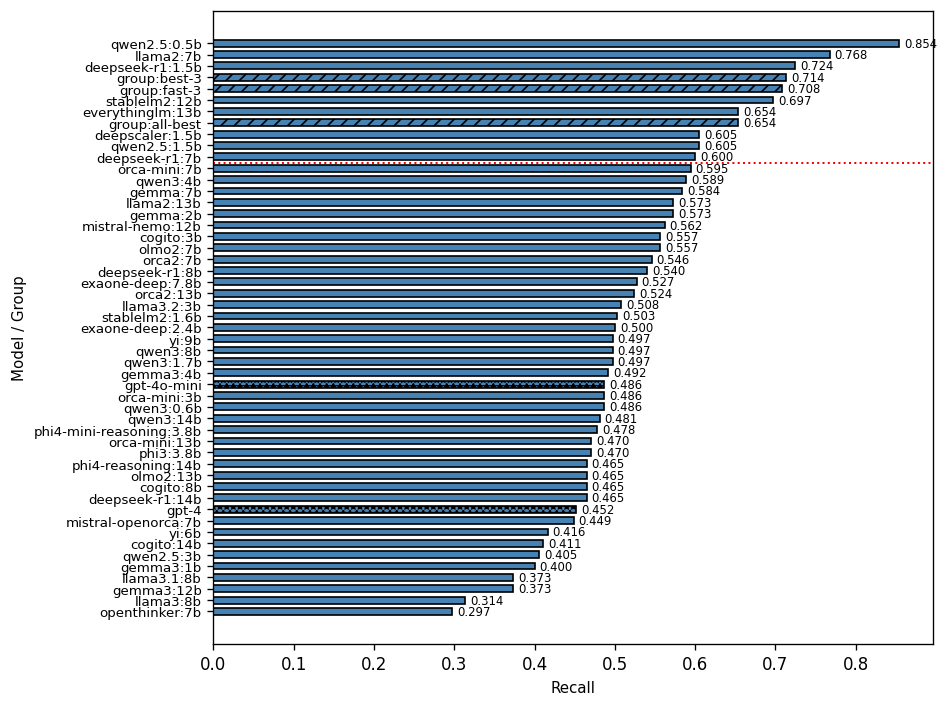

In [265]:
gen_hbar_graph(metrics_df, 'recall', 'Recall', threshold_line_value=0.6)

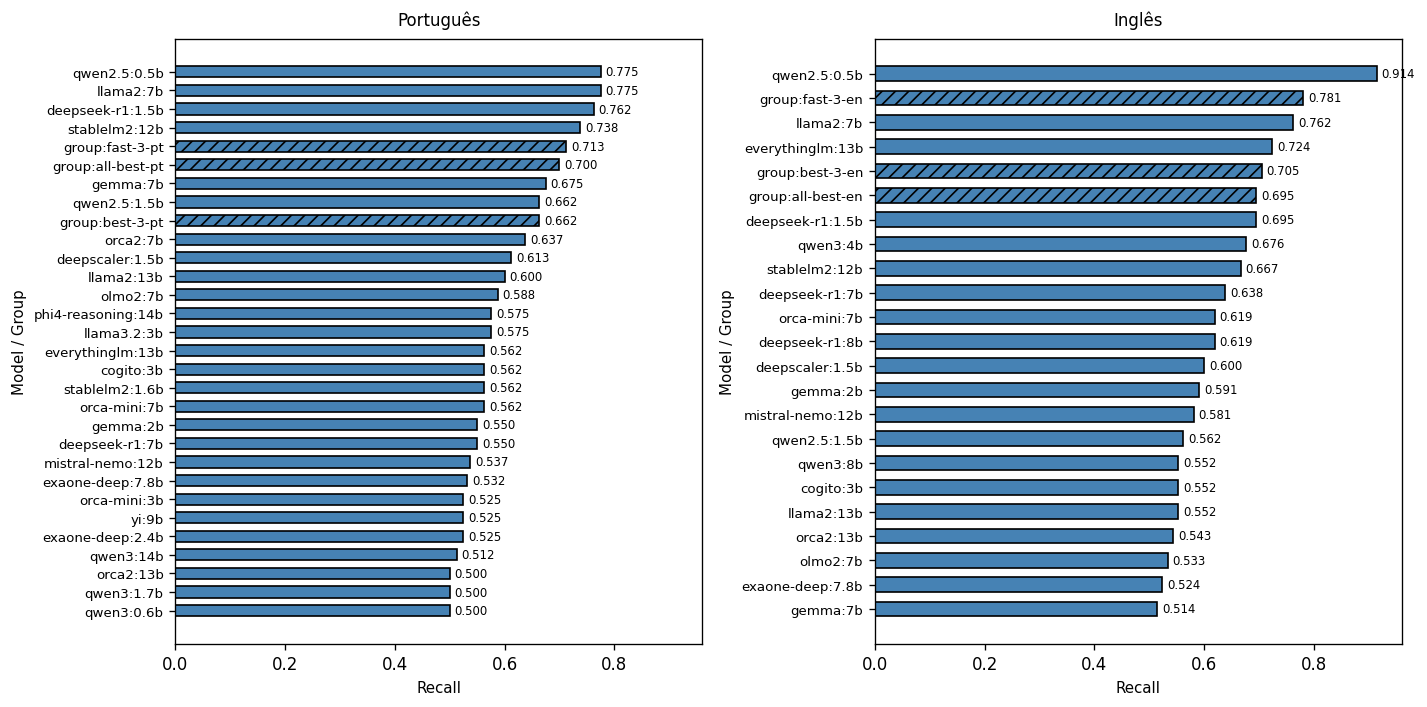

In [281]:
gen_lang_comparison_hbar_graph(metrics_df, 'recall', 'Recall', recall_threshold=0.5)

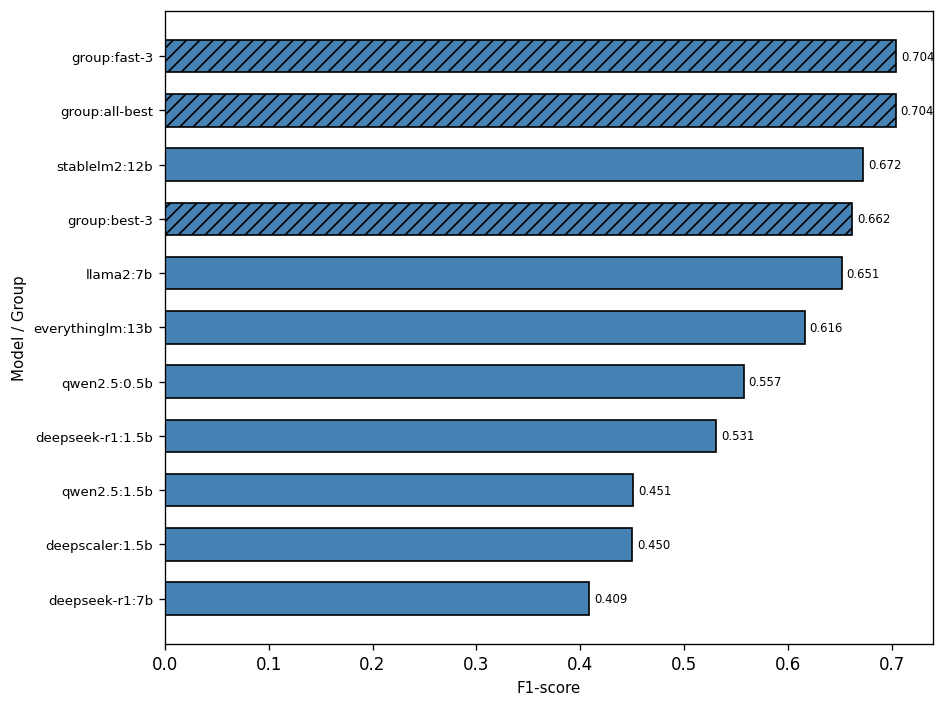

In [267]:
gen_hbar_graph(metrics_df, 'f1_score', 'F1-score', recall_threshold=RECALL_THRESHOLD)

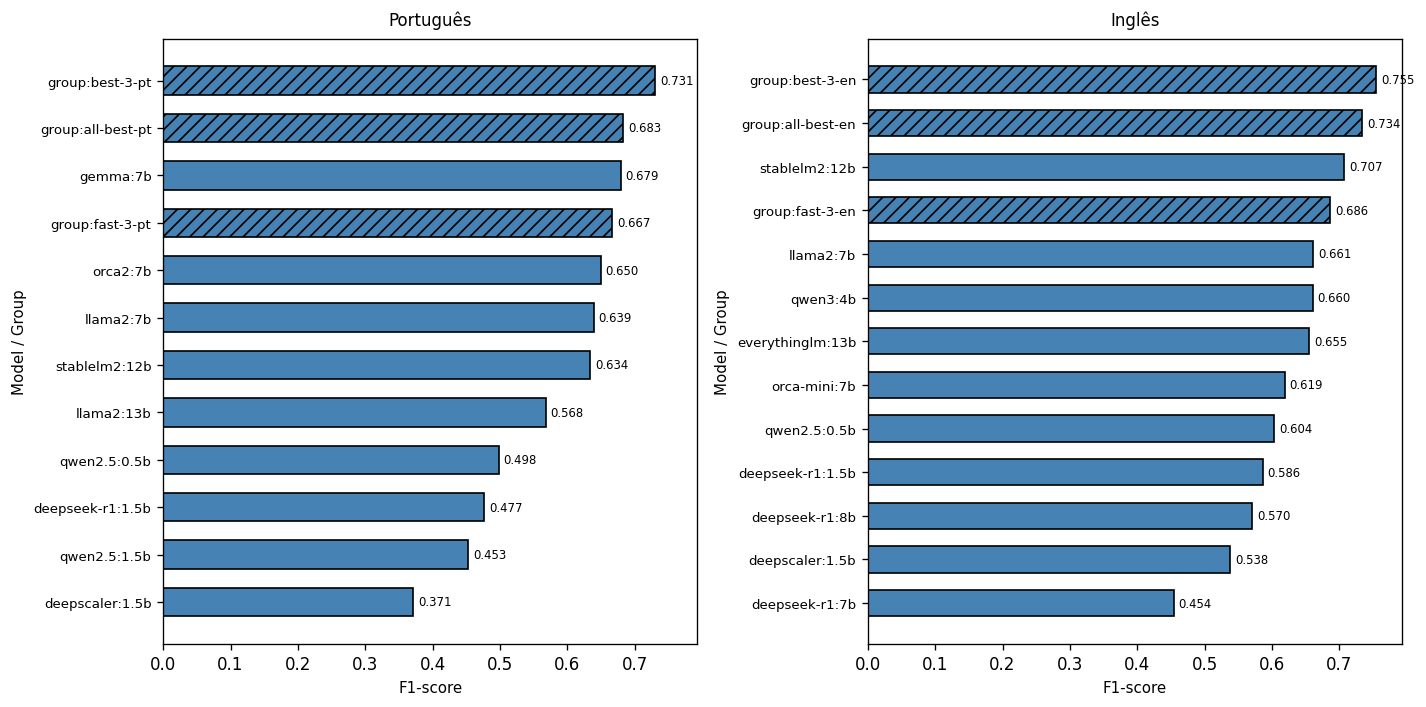

In [268]:
gen_lang_comparison_hbar_graph(metrics_df, 'f1_score', 'F1-score', recall_threshold=RECALL_THRESHOLD)

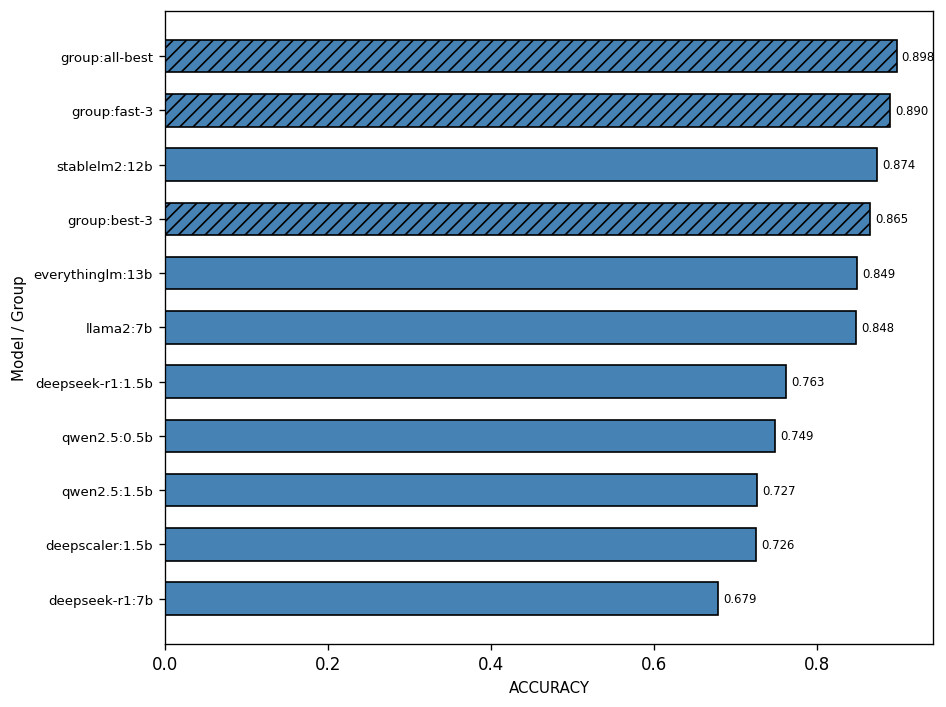

In [269]:
gen_hbar_graph(metrics_df, 'accuracy', 'ACCURACY', recall_threshold=RECALL_THRESHOLD)

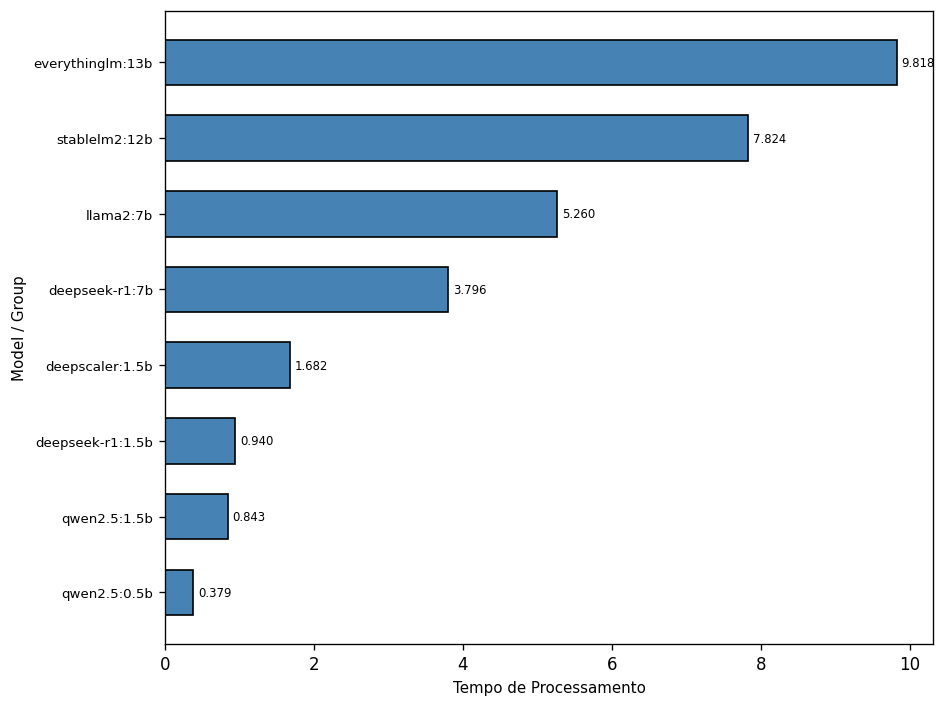

In [282]:
gen_hbar_graph(metrics_df[~metrics_df['model'].str.startswith('group')], 'avg_processing_time', 'Tempo de Processamento', recall_threshold=THRESHOLD)

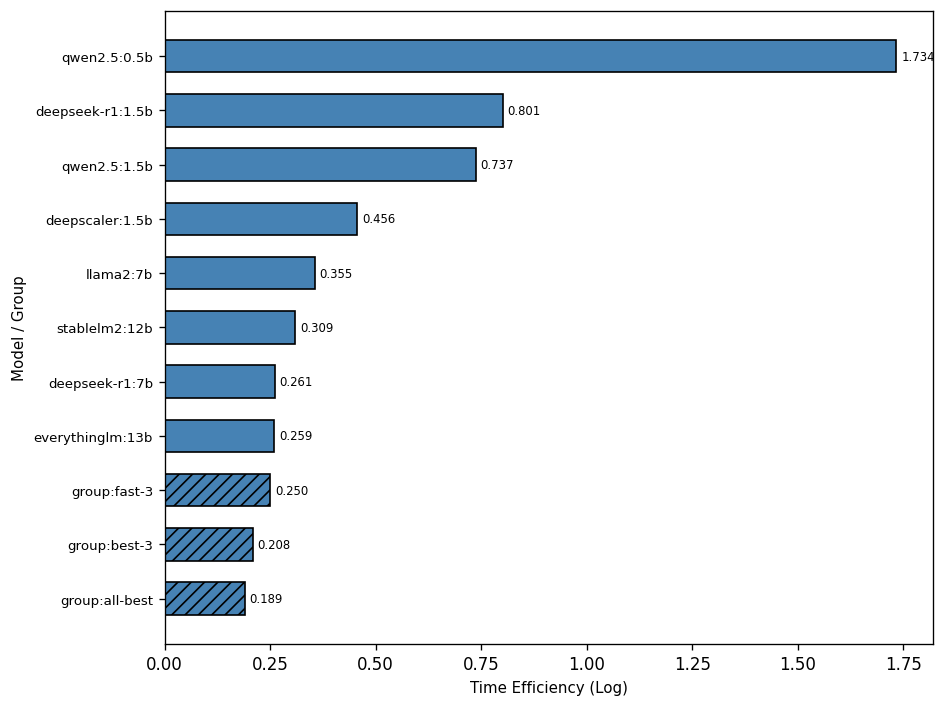

In [271]:
gen_hbar_graph(metrics_df, 'time_efficiency_log', 'Time Efficiency (Log)', recall_threshold=THRESHOLD)

In [272]:
def plot_confusion_matrix(
    df,
    mode='overall',                # 'overall', 'langs', or 'all'
    real_col='real_rating',
    pred_col='manual_prediction',
    lang_col='language',
    labels=None,
    cmap=plt.cm.Blues,
    figsize=(8, 6),
    titles=('Todos', 'PT', 'EN'),
    border_cells=(1,2,6,7,8,12,13,14,18,19,20,24,25),
    border_kwargs=None,
    invert_highlight=False,
    show_title=True,
    xlabel='Predição Manual',      # Novo parâmetro para o eixo X
    ylabel='Real'                   # Novo parâmetro para o eixo Y
):
    """
    Plota matriz(s) de confusão com várias opções de personalização.

    Parâmetros:
      - df: DataFrame com os dados.
      - mode: 'overall', 'langs', ou 'all'.
      - real_col, pred_col, lang_col: Nomes das colunas.
      - labels: Ordem dos labels para os eixos.
      - cmap: Colormap para o heatmap.
      - figsize: Tamanho para cada subplot.
      - titles: Títulos para os gráficos.
      - border_cells: Índices (1-based) das células a destacar.
      - border_kwargs: Dicionário com estilos da borda.
      - invert_highlight: bool, inverte o destaque das células.
      - show_title: bool, controla a exibição do título.
      - xlabel, ylabel: str, rótulos para os eixos X e Y.
    """
    if border_kwargs is None:
        border_kwargs = dict(edgecolor='black', facecolor='none', linewidth=3)

    # Infere os labels se não forem fornecidos
    if labels is None:
        y_true_all = df[real_col]
        y_pred_all = df[pred_col]
        labels = sorted(np.unique(np.concatenate([y_true_all.unique(), y_pred_all.unique()])))

    # Inverte as células destacadas se solicitado
    cells_to_highlight = set(border_cells)
    if invert_highlight:
        num_labels = len(labels)
        total_cells = num_labels * num_labels
        all_cell_indices = set(range(1, total_cells + 1))
        cells_to_highlight = all_cell_indices - cells_to_highlight

    # Prepara os subconjuntos de dados para plotar
    subsets = []
    if mode in ('overall', 'all'):
        subsets.append((titles[0], df))
    if mode in ('langs', 'all'):
        subsets.append((titles[1], df[df[lang_col]=='pt']))
        subsets.append((titles[2], df[df[lang_col]=='en']))

    n = len(subsets)
    if n == 0:
        raise ValueError("O modo deve ser 'overall', 'langs' ou 'all'")
        
    fig, axes = plt.subplots(
        ncols=n,
        figsize=(figsize[0] * n, figsize[1]),
        sharey=True,
        dpi=120
    )
    if n == 1:
        axes = [axes]

    # Itera sobre cada subconjunto para criar um gráfico
    for ax, (title, subdf) in zip(axes, subsets):
        if subdf.empty:
            if show_title:
                ax.set_title(title)
            ax.text(0.5, 0.5, "Sem dados", ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Calcula a matriz de confusão e as percentagens
        y_true = subdf[real_col]
        y_pred = subdf[pred_col]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_perc = np.round(cm / cm.sum(axis=1, keepdims=True) * 100, 1)
        cm_perc = np.nan_to_num(cm_perc)

        # Desenha o heatmap
        ax.imshow(cm_perc, interpolation='nearest', cmap=cmap, vmin=0, vmax=100)
        
        # Configura eixos e título usando os novos parâmetros
        plot_title = title if show_title else ''
        is_first_plot = (ax == axes[0])
        ax.set(
            xticks=np.arange(len(labels)),
            yticks=np.arange(len(labels)),
            xticklabels=labels,
            yticklabels=labels,
            xlabel=xlabel,
            ylabel=ylabel if is_first_plot else '', # Mostra o rótulo Y apenas no primeiro gráfico
            title=plot_title
        )
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Adiciona anotações de texto e bordas nas células
        thresh = 50 # Limiar para a cor do texto (branco ou preto)
        rows, cols = cm.shape
        for i in range(rows):
            for j in range(cols):
                cell_num = i * cols + j + 1
                cnt = cm[i, j]
                pct = cm_perc[i, j]
                txt = f"{cnt}\n({pct:.1f}%)"
                
                weight = 'bold' if cell_num in cells_to_highlight else 'normal'
                color_txt = 'white' if pct > thresh else 'black'
                
                ax.text(j, i, txt,
                        ha='center', va='center',
                        fontsize=10, fontweight=weight, color=color_txt)
                
                if cell_num in cells_to_highlight:
                    ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, **border_kwargs))

    plt.tight_layout()
    plt.show()
    return fig, axes


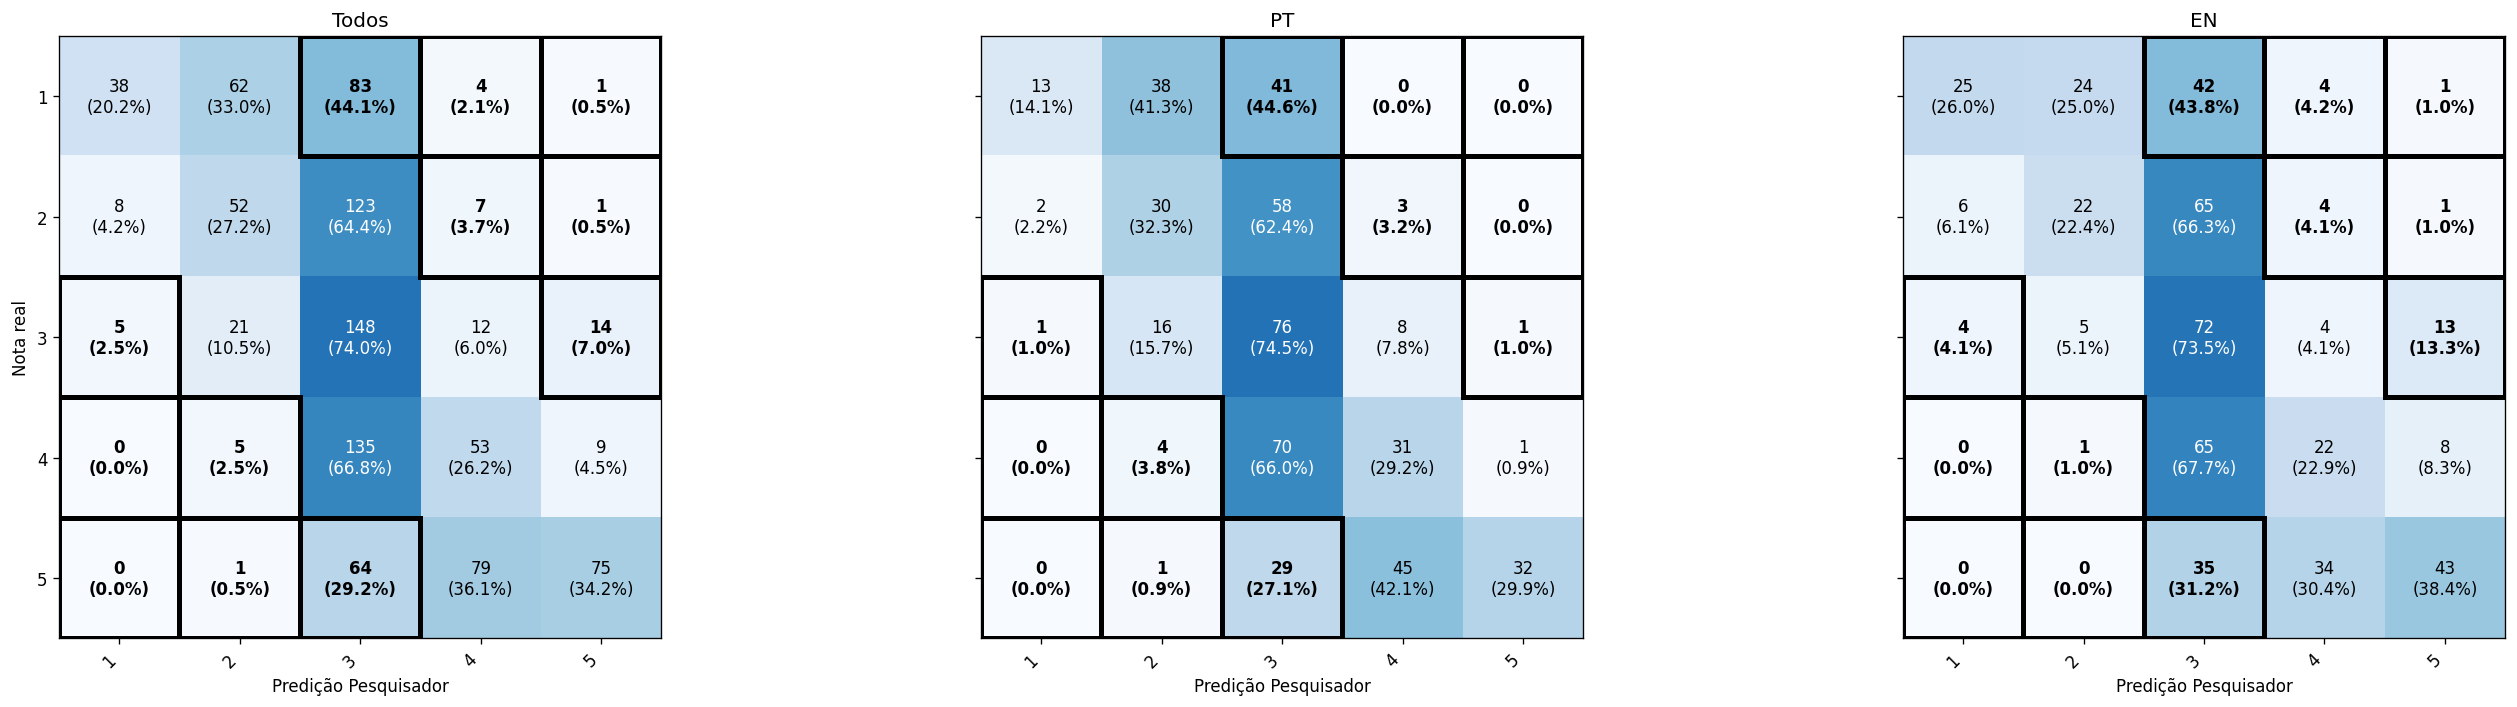

(<Figure size 2880x720 with 3 Axes>,
 array([<Axes: title={'center': 'Todos'}, xlabel='Predição Pesquisador', ylabel='Nota real'>,
        <Axes: title={'center': 'PT'}, xlabel='Predição Pesquisador'>,
        <Axes: title={'center': 'EN'}, xlabel='Predição Pesquisador'>],
       dtype=object))

In [273]:
plot_confusion_matrix(
    df[df['model']==groups['group:best-3'][0]],
    mode='all',             # 'overall', 'langs', or 'all'
    real_col='real_rating',
    pred_col='manual_rating',
    ylabel='Nota real',
    xlabel='Predição Pesquisador',
    invert_highlight=True
)

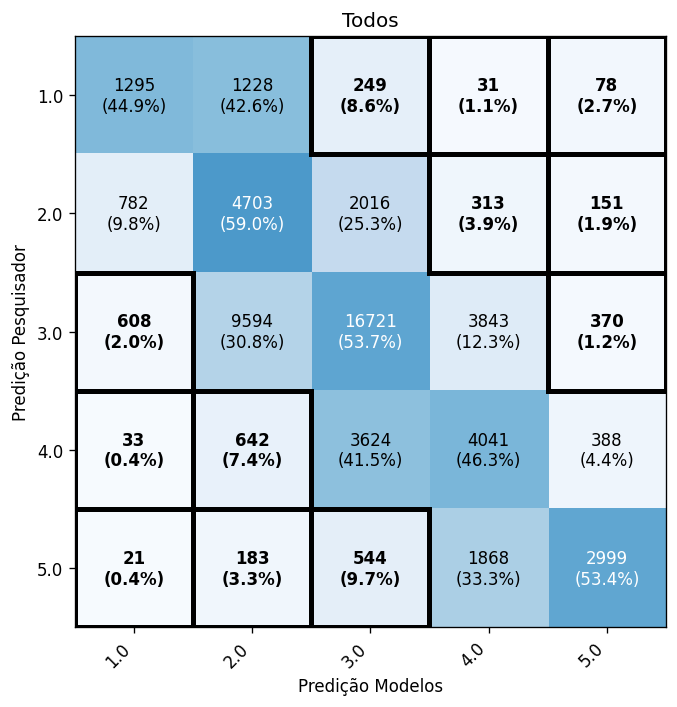

(<Figure size 960x720 with 1 Axes>,
 [<Axes: title={'center': 'Todos'}, xlabel='Predição Modelos', ylabel='Predição Pesquisador'>])

In [274]:
plot_confusion_matrix(
    df,
    mode='overall',             # 'overall', 'langs', or 'all'
    real_col='manual_rating',
    pred_col='model_rating',
    ylabel='Predição Pesquisador',
    xlabel='Predição Modelos',
    invert_highlight=True
)

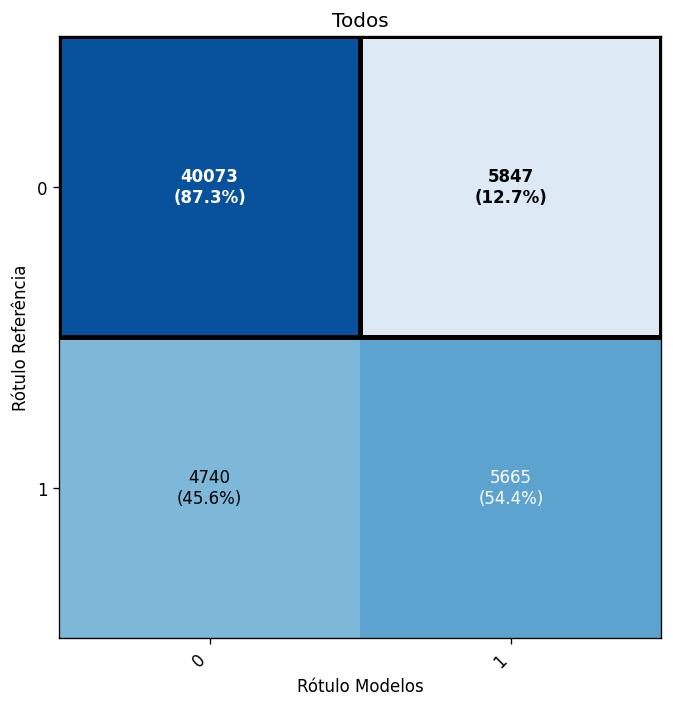

(<Figure size 960x720 with 1 Axes>,
 [<Axes: title={'center': 'Todos'}, xlabel='Rótulo Modelos', ylabel='Rótulo Referência'>])

In [283]:
plot_confusion_matrix(
    df,
    mode='overall',             # 'overall', 'langs', or 'all'
    real_col='is_inconsistent_manual',
    pred_col='is_inconsistent_model',
    ylabel='Rótulo Referência',
    xlabel='Rótulo Modelos'
)

In [276]:
def plot_confusion_matrix_real_rating(
    df,
    mode='all',                  
    filter_col='real_rating',
    real_col='manual_rating',
    pred_col='model_rating',
    real_label='Nota predita manual',
    pred_label='Nota predita LLMs'
):
    """
    Plota 5 matrizes de confusão (uma para cada valor de 1 a 5 em `filter_col`),
    quebradas em duas linhas, com coloração baseada na contagem absoluta.
    """
    # filtra por linguagem
    if mode == 'pt':
        df_mode = df[df['language']=='pt']
    elif mode == 'en':
        df_mode = df[df['language']=='en']
    else:
        df_mode = df.copy()

    # categorias comuns
    vals_true = df_mode[real_col].dropna().unique()
    vals_pred = df_mode[pred_col].dropna().unique()
    labels = np.unique(np.concatenate([vals_true, vals_pred]))

    ratings = [1,2,3,4,5]
    n = len(ratings)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(5*ncols, 5*nrows), dpi=120,
                             sharey=True)
    axes_flat = axes.flatten()

    for idx, r in enumerate(ratings):
        ax = axes_flat[idx]
        sub = df_mode[df_mode[filter_col] == r]
        y_true = sub[real_col]
        y_pred = sub[pred_col]

        cm = confusion_matrix(y_true, y_pred, labels=labels)
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm_perc = np.round(cm / cm_sum * 100, 1)

        # coloração por contagem absoluta
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Contagem', fontweight='bold')

        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_yticklabels(labels)
        ax.set_xlabel(pred_label)
        if idx % ncols == 0:
            ax.set_ylabel(real_label)
        ax.set_title(f'{filter_col} = {r}', fontsize=12, fontweight='bold')

        thresh = cm.max() / 2
        rows, cols = cm.shape
        for i in range(rows):
            for j in range(cols):
                cnt = cm[i, j]
                pct = cm_perc[i, j]
                txt = f"{cnt}\n({pct:.1f}%)"
                color_txt = 'white' if cnt > thresh else 'black'
                ax.text(j, i, txt, ha='center', va='center',
                        fontsize=9, color=color_txt)

    # desliga plots extras
    for ax in axes_flat[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    return fig, axes


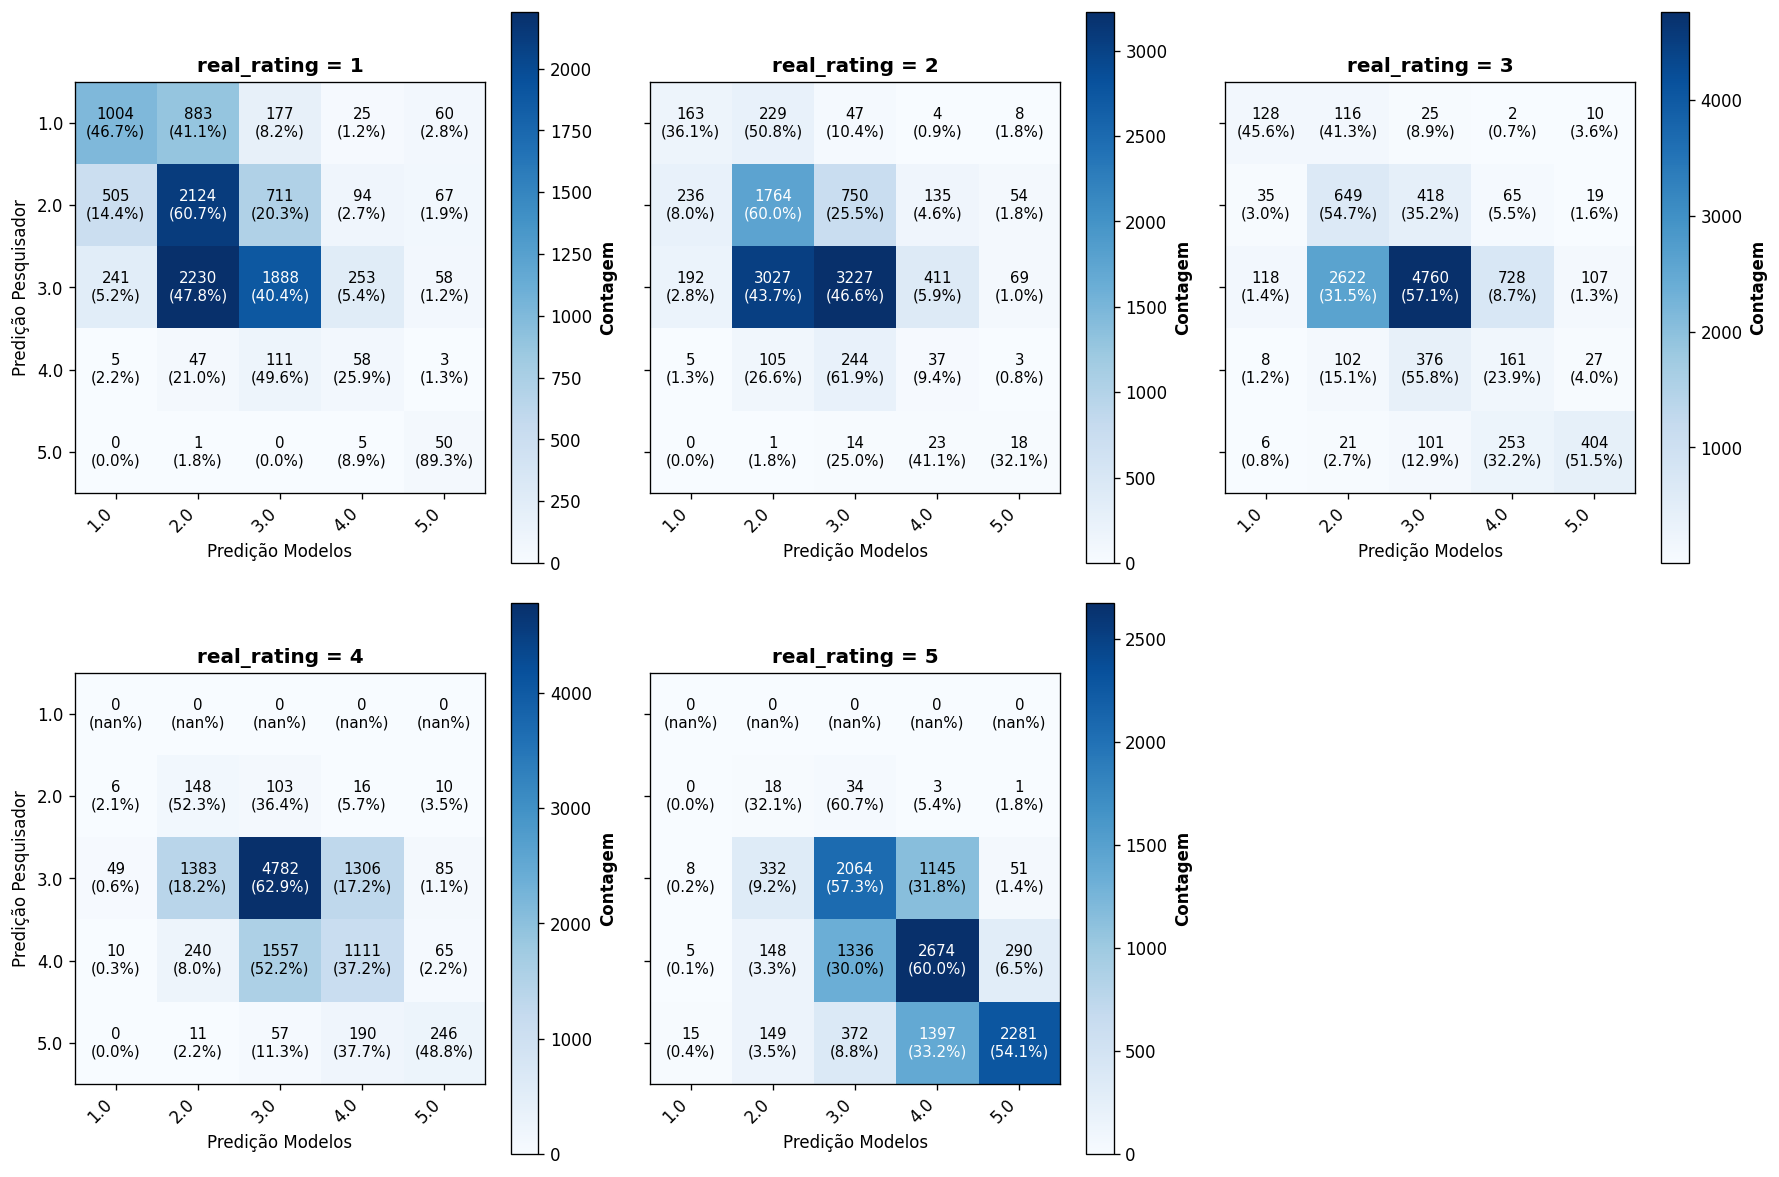

(<Figure size 1800x1200 with 11 Axes>,
 array([[<Axes: title={'center': 'real_rating = 1'}, xlabel='Predição Modelos', ylabel='Predição Pesquisador'>,
         <Axes: title={'center': 'real_rating = 2'}, xlabel='Predição Modelos'>,
         <Axes: title={'center': 'real_rating = 3'}, xlabel='Predição Modelos'>],
        [<Axes: title={'center': 'real_rating = 4'}, xlabel='Predição Modelos', ylabel='Predição Pesquisador'>,
         <Axes: title={'center': 'real_rating = 5'}, xlabel='Predição Modelos'>,
         <Axes: >]], dtype=object))

In [277]:
plot_confusion_matrix_real_rating(
    df,
    mode='all',             # 'all', 'en', or 'pt'
    real_col='manual_rating',
    pred_col='model_rating',
    real_label='Predição Pesquisador',
    pred_label='Predição Modelos'
)

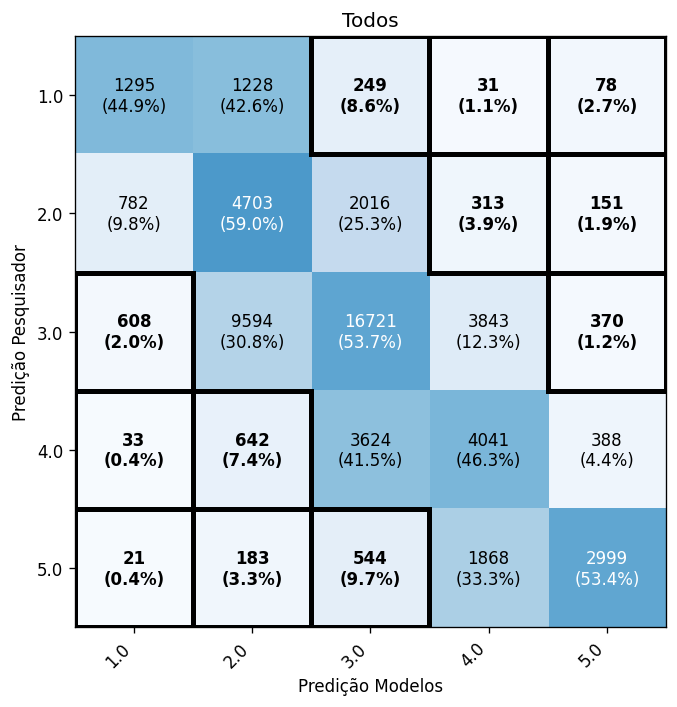

(<Figure size 960x720 with 1 Axes>,
 [<Axes: title={'center': 'Todos'}, xlabel='Predição Modelos', ylabel='Predição Pesquisador'>])

In [278]:
plot_confusion_matrix(
    df,
    mode='overall',             # 'overall', 'langs', or 'all'
    real_col='manual_rating',
    pred_col='model_rating',
    ylabel='Predição Pesquisador',
    xlabel='Predição Modelos',
    invert_highlight=True
)

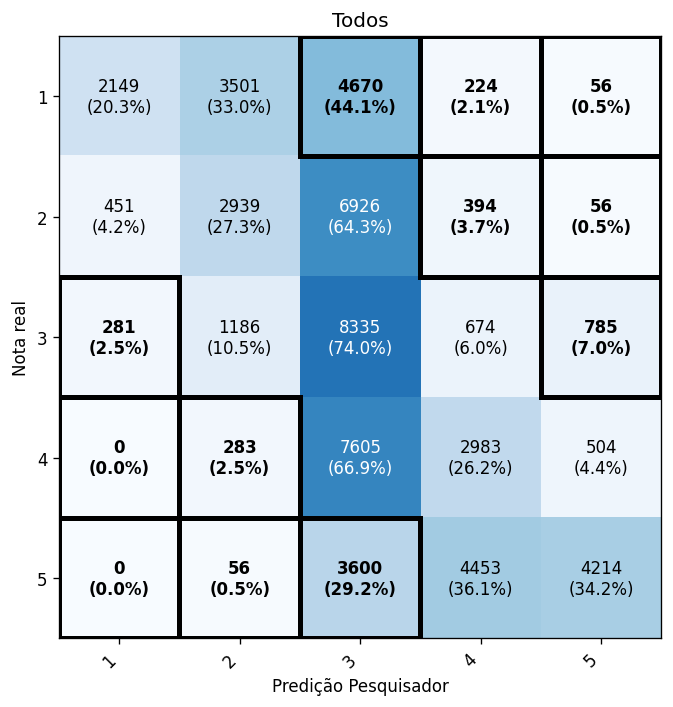

(<Figure size 960x720 with 1 Axes>,
 [<Axes: title={'center': 'Todos'}, xlabel='Predição Pesquisador', ylabel='Nota real'>])

In [279]:
plot_confusion_matrix(
    df,
    mode='overall',             # 'overall', 'langs', or 'all'
    real_col='real_rating',
    pred_col='manual_rating',
    ylabel='Nota real',
    xlabel='Predição Pesquisador',
    invert_highlight=True
)

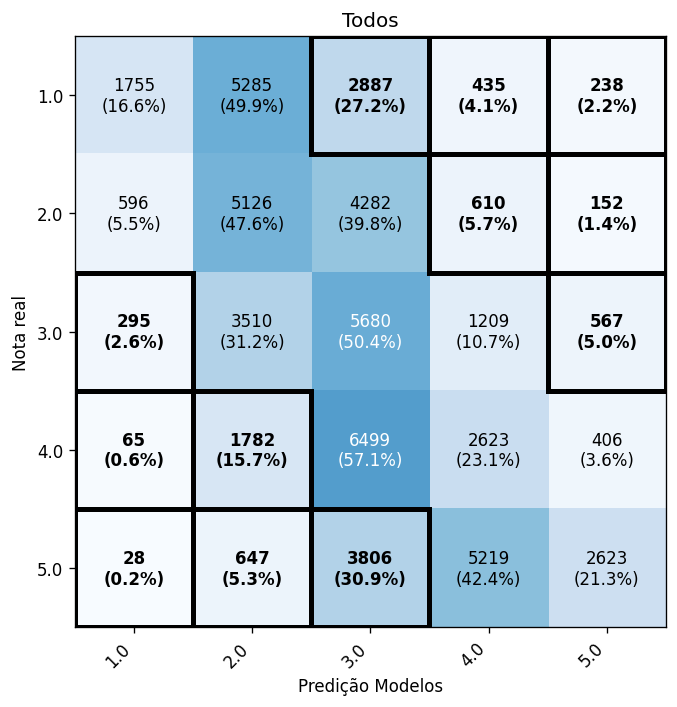

(<Figure size 960x720 with 1 Axes>,
 [<Axes: title={'center': 'Todos'}, xlabel='Predição Modelos', ylabel='Nota real'>])

In [280]:
plot_confusion_matrix(
    df,
    mode='overall',             # 'overall', 'langs', or 'all'
    real_col='real_rating',
    pred_col='model_rating',
    ylabel='Nota real',
    xlabel='Predição Modelos',
    invert_highlight=True
)